In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed
import pickle 
import os 

def plot_setup():
    plt.rcParams['text.usetex'] = False
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['mathtext.fontset'] = 'cm'
    # plt.rcParams['figure.autolayout'] = 'True'

    sns.set_style('ticks',{'axes.edgecolor': '[0,0,0]',
                           'xtick.direction':'in',
                           'ytick.direction':'in',
                           'ytick.right':'True',
                           'xtick.top':'True',
                           'xtick.color':'k',
                           'ytick.color':'k'
                            })

def gammafunc(size,mu,diff_flag):
    if diff_flag == 1:
        return 6*np.pi*mu*0.005*size
    else:
        return 6*np.pi*mu*0.005*3
    
def diffusion(size,sigma,mu,diff_flag):
    gamma_m = 6*np.pi*0.3*0.01
    gamma = gammafunc(size,mu,diff_flag)
    return ((sigma/(gamma_m+gamma))**2)/2

def diffusion_fluid_drag(size,sigma,mu):
    gamma_m = 6*np.pi*0.3*0.01
    gamma = gammafunc(size,mu,diff_flag)
    return ((sigma/(gamma_m+gamma))**2)/2

def velocity_fluid_drag(size,mu):
    a = 0.005*size
    gamma_m = 6*np.pi*0.3*0.01
    return (6*np.pi*mu*a)/(gamma_m + 6*np.pi*mu*a)

def Pe(r,vc):
    return [np.sqrt(np.dot(vc,vc))/np.sqrt(np.dot(v-vc,v-vc)) for v in r]

def Sp(r,vc):
    return [np.dot(v,vc)/np.sqrt(np.dot(vc,vc)) for v in r]

def mc(mu,sigma,kon,kon1,M,model,diff_flag):    
    tend = 500
    koff = 1
    vc = np.array([-0.1,0])
    M = int(M)

    pe = np.empty((tend,M))
    sp = np.empty_like(pe)
    velos = np.empty((tend,M,2))
    size = np.empty_like(pe)
    disp = np.empty_like(pe)
    state = np.zeros_like(pe)

    if model == 1:
        for j in range(M):
            cov = 2*diffusion(j+1,sigma,mu,diff_flag)*np.eye(2)
            size[:,j] = j+1
            v = np.random.default_rng().multivariate_normal(vc,cov,tend)
            velos[:,j,:] = v
            pe[:,j] = Pe(v,vc)
            sp[:,j] = Sp(v,vc)
            disp[:,j] = np.sqrt(np.sum(v**2))
    elif model == 2:
        for j in range(M):
            cov = 2*diffusion(j+1,sigma,mu,diff_flag)*np.eye(2)
            size[:,j] = j+1
            num_bound = np.random.default_rng().binomial(tend,kon/(kon+koff))
            vb = np.random.default_rng().multivariate_normal(vc,cov,num_bound)
            vu = np.random.default_rng().multivariate_normal(np.array([0,0]),cov,tend-num_bound)
            v = np.concatenate((vb,vu))
            velos[:,j,:] = v
            state[0:num_bound,j] = 1
            pe[:,j] = Pe(v,vc)
            sp[:,j] = Sp(v,vc)
            disp[:,j] = np.sqrt(np.sum(v**2))
    elif model == 3:
        kon = 5
        for j in range(M):
            cov = 2*diffusion(j+1,sigma,mu,diff_flag)*np.eye(2)
            size[:,j] = j+1
            num_bound = np.random.default_rng().binomial(tend,(kon+kon1*j)/(kon+kon1*j+koff))
            vb = np.random.default_rng().multivariate_normal(vc,cov,num_bound)
            vu = np.random.default_rng().multivariate_normal(np.array([0,0]),cov,tend-num_bound)
            v = np.concatenate((vb,vu))
            velos[:,j,:] = v
            state[0:num_bound,j] = 1
            pe[:,j] = Pe(v,vc)
            sp[:,j] = Sp(v,vc)
            disp[:,j] = np.sqrt(np.sum(v**2))
    elif model == 4:
        for j in range(M):
            cov = 2*diffusion(j+1,sigma,mu,diff_flag)*np.eye(2)
            velo_coef = velocity_fluid_drag(j+1,mu)
            size[:,j] = j+1
            v = np.random.default_rng().multivariate_normal(velo_coef*vc,cov,tend)
            velos[:,j,:] = v
            pe[:,j] = Pe(v,vc)
            sp[:,j] = Sp(v,vc)
            disp[:,j] = np.sqrt(np.sum(v**2))

    return pe, sp, velos, size, disp, state

In [2]:
def make_boxplots(out,M,models,pars,fname):
    pe, sp, velos, size, disp, state = zip(*out)
    pars_arr = np.array(pars)
    colors = ['C0','C1','C2','C3']
    Ynum = int(np.shape(pars_arr)[0]/4)
    
    labels = ['1-3','4-6','7-9','10-12']
    groups = [(0,1,2),(3,4,5),(6,7,8),(9,10,11)]
    expt = [1,1.25,1.5,1.75]

    data = np.empty((len(models),len(groups),int(len(groups[0])*Ynum*500)))
    for i in range(len(models)):
        mod = models[i]
        idx = (pars_arr[:,-1]==mod)

        Y = np.array(pe)
        for j in range(len(groups)):
            data[i,j,:] = (Y[idx,:,groups[j][0]:groups[j][-1]+1].ravel())

    fig, axes = plt.subplots(1,4, figsize=(6,2), sharey=True, constrained_layout=True)

    for i in range(len(models)):
        mod = models[i]
        ax = axes[i]
        bp = ax.boxplot(data[i,:].T,labels=labels,showfliers=False,patch_artist=True)
        ax.set_xticklabels(labels)
        ax.set_xlabel('Cluster Size')
        ax.set_yticks(np.arange(0,6))
        ax.set_ylim((0,5))

        ax.plot(np.arange(1,5),expt,'ko:',zorder=10)

        for patch in bp['boxes']:
            patch.set_facecolor(colors[i])
        for median in bp['medians']:
            median.set_color('k')
        ax.set_title('Model '+str(mod),fontsize=10)
    axes[0].set_ylabel('Péclet Number')

    fig.canvas.draw()
    labels = ['A','B','C','D']
    for ax, label in zip(axes, labels):
        bbox = ax.get_tightbbox(fig.canvas.get_renderer())
        fig.text(bbox.x0, bbox.y1, label,
                 transform=None,va='top')

    fig.savefig(fname+'.pdf',format='pdf')

In [3]:
def make_lineplots(sizediff,constdiff,M,models,pars,fname):
    
    #size dependent diffusion
    pe, sp, velos, size, disp, state = zip(*sizediff)
    pars_arr = np.array(pars)
    colors = ['C0','C1','C2','C3']
    
    M = 10 #UPDATE THIS TO BE MAX CLUSTER SIZE PLOTTED
    x = np.arange(1,M+1)

    fig, axes = plt.subplots(2,2, figsize=(5,4), sharex=True, constrained_layout=True)

    for i in range(len(models)):
        mod = models[i]
        idx = (pars_arr[:,-1]==mod)

        Yavg = np.empty(M)
        Ystd = np.empty_like(Yavg)
        Ynum = np.shape(pars_arr[idx,:])[0]

        Y = np.array(pe)
        for j in range(M):
            Yavg[j] = np.mean(Y[idx,:,j].ravel())
            Ystd[j] = np.std(Y[idx,:,j].ravel())

        axes[0,0].fill_between(x = x,
                            y1 = Yavg - Ystd/np.sqrt(Ynum),
                            y2 = Yavg + Ystd/np.sqrt(Ynum),
                            alpha = 0.3,
                            color=colors[i])
        axes[0,0].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color=colors[i],
                         label=str(mod))

        Y = np.array(sp)
        for j in range(M):
            Yavg[j] = np.mean(Y[idx,:,j].ravel())
            Ystd[j] = np.std(Y[idx,:,j].ravel())

        axes[0,1].fill_between(x = x,
                            y1 = Yavg - Ystd/np.sqrt(Ynum),
                            y2 = Yavg + Ystd/np.sqrt(Ynum),
                            alpha = 0.3,
                            color=colors[i])
        axes[0,1].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color=colors[i],
                         label=str(mod))
        
        
    #size INdependent diffusion
    pe, sp, velos, size, disp, state = zip(*constdiff)    
    for i in range(len(models)):
        mod = models[i]
        idx = (pars_arr[:,-1]==mod)

        Yavg = np.empty(M)
        Ystd = np.empty_like(Yavg)
        Ynum = np.shape(pars_arr[idx,:])[0]

        Y = np.array(pe)
        for j in range(M):
            Yavg[j] = np.mean(Y[idx,:,j].ravel())
            Ystd[j] = np.std(Y[idx,:,j].ravel())

        axes[1,0].fill_between(x = x,
                            y1 = Yavg - Ystd/np.sqrt(Ynum),
                            y2 = Yavg + Ystd/np.sqrt(Ynum),
                            alpha = 0.3,
                            color=colors[i])
        axes[1,0].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color=colors[i],
                         label=str(mod))

        Y = np.array(sp)
        for j in range(M):
            Yavg[j] = np.mean(Y[idx,:,j].ravel())
            Ystd[j] = np.std(Y[idx,:,j].ravel())

        axes[1,1].fill_between(x = x,
                            y1 = Yavg - Ystd/np.sqrt(Ynum),
                            y2 = Yavg + Ystd/np.sqrt(Ynum),
                            alpha = 0.3,
                            color=colors[i])
        axes[1,1].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color=colors[i],
                         label=str(mod))
        
    for ax in axes.ravel():
        ax.set_xticks(np.arange(1,M+1))

    for ax in axes[:,0]:
        ax.set_ylabel('Péclet Number')
        ax.set_ylim((0,4))
        ax.set_yticks(np.linspace(0,4,5))
    
    for ax in axes[:,1]:
        ax.set_ylabel('Scalar Projection')
        ax.set_ylim((0,0.125))
        ax.set_yticks(np.linspace(0,0.125,6))
    
    axes[0,0].legend(loc=2,ncol=2,title='Model')
    
    for ax in axes[1,:]:
        ax.set_xlabel('Cluster Size')

    labels = ['A','B','C','D']
    fig.canvas.draw()
    for ax, label in zip(axes.ravel(), labels):
        bbox = ax.get_tightbbox(fig.canvas.get_renderer())
        fig.text(bbox.x0, bbox.y1, label,
                 transform=None,va='top')
        
    fig.savefig(fname+'.pdf',format='pdf')
    
def make_lineplots_v2(sizediff,constdiff,M,models,pars,fname):
    
    #size dependent diffusion
    pe, sp, velos, size, disp, state = zip(*sizediff)
    pars_arr = np.array(pars)
    colors = ['C0','C1','C2','C3']
    
    M = 10 #UPDATE THIS TO BE MAX CLUSTER SIZE PLOTTED
    x = np.arange(1,M+1)

    fig = plt.figure(constrained_layout=True, figsize=(6,5))
    subfigs = fig.subfigures(2, 1, wspace=0.07)
    
    axestop = subfigs[0].subplots(1,2)
    axesbottom = subfigs[1].subplots(1,2)
    
    subfigs[0].set_facecolor('0.95')

    for i in range(len(models)):
        mod = models[i]
        idx = (pars_arr[:,-1]==mod)

        Yavg = np.empty(M)
        Ystd = np.empty_like(Yavg)
        Ynum = np.shape(pars_arr[idx,:])[0]

        Y = np.array(pe)
        for j in range(M):
            Yavg[j] = np.mean(Y[idx,:,j].ravel())
            Ystd[j] = np.std(Y[idx,:,j].ravel())

        axestop[0].fill_between(x = x,
                            y1 = Yavg - Ystd/np.sqrt(Ynum),
                            y2 = Yavg + Ystd/np.sqrt(Ynum),
                            alpha = 0.3,
                            color=colors[i])
        axestop[0].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color=colors[i],
                         label=str(mod))

        Y = np.array(sp)
        for j in range(M):
            Yavg[j] = np.mean(Y[idx,:,j].ravel())
            Ystd[j] = np.std(Y[idx,:,j].ravel())

        axestop[1].fill_between(x = x,
                            y1 = Yavg - Ystd/np.sqrt(Ynum),
                            y2 = Yavg + Ystd/np.sqrt(Ynum),
                            alpha = 0.3,
                            color=colors[i])
        axestop[1].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color=colors[i],
                         label=str(mod))
        
        
    #size INdependent diffusion
    pe, sp, velos, size, disp, state = zip(*constdiff)    
    for i in range(len(models)):
        mod = models[i]
        idx = (pars_arr[:,-1]==mod)

        Yavg = np.empty(M)
        Ystd = np.empty_like(Yavg)
        Ynum = np.shape(pars_arr[idx,:])[0]

        Y = np.array(pe)
        for j in range(M):
            Yavg[j] = np.mean(Y[idx,:,j].ravel())
            Ystd[j] = np.std(Y[idx,:,j].ravel())

        axesbottom[0].fill_between(x = x,
                            y1 = Yavg - Ystd/np.sqrt(Ynum),
                            y2 = Yavg + Ystd/np.sqrt(Ynum),
                            alpha = 0.3,
                            color=colors[i])
        axesbottom[0].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color=colors[i],
                         label=str(mod))

        Y = np.array(sp)
        for j in range(M):
            Yavg[j] = np.mean(Y[idx,:,j].ravel())
            Ystd[j] = np.std(Y[idx,:,j].ravel())

        axesbottom[1].fill_between(x = x,
                            y1 = Yavg - Ystd/np.sqrt(Ynum),
                            y2 = Yavg + Ystd/np.sqrt(Ynum),
                            alpha = 0.3,
                            color=colors[i])
        axesbottom[1].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color=colors[i],
                         label=str(mod))
        
    for ax in axestop.ravel():
        ax.set_xticks(np.arange(1,M+1))
        ax.set_xlabel('Cluster Size')

    for ax in axesbottom.ravel():
        ax.set_xticks(np.arange(1,M+1))
        ax.set_xlabel('Cluster Size')
        
    for ax in [axestop[0],axesbottom[0]]:
        ax.set_ylabel('Péclet Number')
        ax.set_ylim((0,4))
        ax.set_yticks(np.linspace(0,4,5))
    
    for ax in [axestop[1],axesbottom[1]]:
        ax.set_ylabel('Scalar Projection')
        ax.set_ylim((0,0.125))
        ax.set_yticks(np.linspace(0,0.125,6))
    
    axestop[0].legend(loc=2,ncol=2,title='Model')
    
    axestop[0].text(-9/72, 1+2/72, 'A', transform=axestop[0].transAxes, va='top')
    axestop[1].text(-17/72, 1+2/72, 'B', transform=axestop[1].transAxes, va='top')
    axesbottom[0].text(-9/72, 1+2/72, 'C', transform=axesbottom[0].transAxes, va='top')
    axesbottom[1].text(-17/72, 1+2/72, 'D', transform=axesbottom[1].transAxes, va='top')

    subfigs[0].suptitle('Size-Dependent Diffusion',fontsize=10)
    subfigs[1].suptitle('Size-Independent Diffusion',fontsize=10)
    fig.savefig(fname+'.pdf',format='pdf')

Plot Setup
Plotting Size-Dependent Diffusion
Plotting Size-Independent Diffusion
Plain Figure 4
Fancy Figure 4


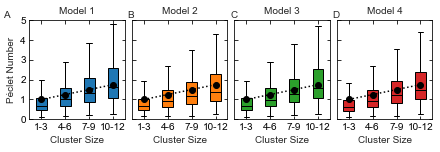

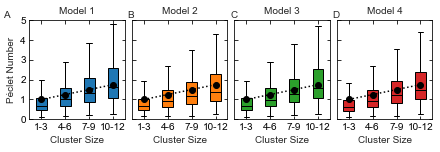

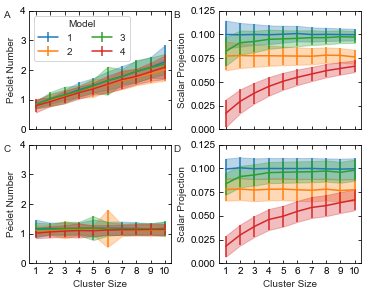

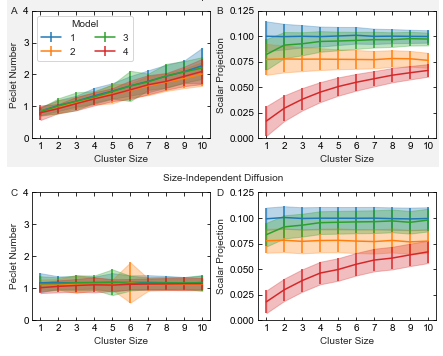

In [5]:
print('Plot Setup')
plot_setup()

if not (os.path.isfile('data/Fig3_Data.pkl') & os.path.isfile('data/Fig3_Data_ConstantDiff.pkl') & os.path.isfile('data/Fig3_ParamSets.pkl')):
    #generate parameter sets
    num_cells = 100
    M = 12
    sigma = 0.01
    mu_list = np.random.default_rng().uniform(0.05,0.2,num_cells)
    kon_list = np.random.default_rng().uniform(0.1,10,num_cells)
    kon1_list = np.random.default_rng().uniform(0,10,num_cells)
    models = [1,2,3,4]
    pars = [(*p,mod) for p in zip(mu_list,sigma*np.ones(num_cells),kon_list,kon1_list,M*np.ones(num_cells)) for mod in models]

    with open('data/Fig3_ParamSets.pkl','wb') as f:
        pickle.dump(list(zip(mu_list,sigma*np.ones(num_cells),kon_list,kon1_list)),f)

    
    print('Simulating Size-Dependent Diffusion')
    diff_flag = 1
    sizediff = Parallel(n_jobs = -1, verbose = 1)(delayed(mc)(*p,diff_flag) for p in pars)

    with open('data/Fig3_Data.pkl','wb') as f:
        pickle.dump(sizediff,f)
    
    print('Simulating Size-Indenpent Diffusion')
    diff_flag = 0
    constdiff = Parallel(n_jobs = -1, verbose = 1)(delayed(mc)(*p,diff_flag) for p in pars)
    
    with open('data/Fig3_Data_ConstantDiff.pkl','wb') as f:
        pickle.dump(constdiff,f)
        
    
print('Plotting Size-Dependent Diffusion')
fname = 'figures/Fig3'
make_boxplots(sizediff,M,models,pars,fname)


print('Plotting Size-Independent Diffusion')
fname = 'figures/Fig3_ConstDiff'
make_boxplots(sizediff,M,models,pars,fname)


print('Plain Figure 4')
fname = 'figures/Fig4_notitles_nobackground'
make_lineplots(sizediff,constdiff,M,models,pars,fname)


print('Fancy Figure 4')
fname = 'figures/Fig4'
make_lineplots_v2(sizediff,constdiff,M,models,pars,fname)